In [1]:
#Beating rate, 90% or 80% contraction amplitude, dp/dt, TTP, time to 90% relaxtion, tau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt,firwin
from scipy.integrate import simps

In [2]:
file_name = "stress_2HZ_4_flood_fill.csv"
df =  pd.read_csv(file_name)
contraction_stress, frame_time_point = df['stress_kpa'] , df['frame'] # [mPa*mm^2] represent - load applied across a certain area, means [10^-9N or nN].

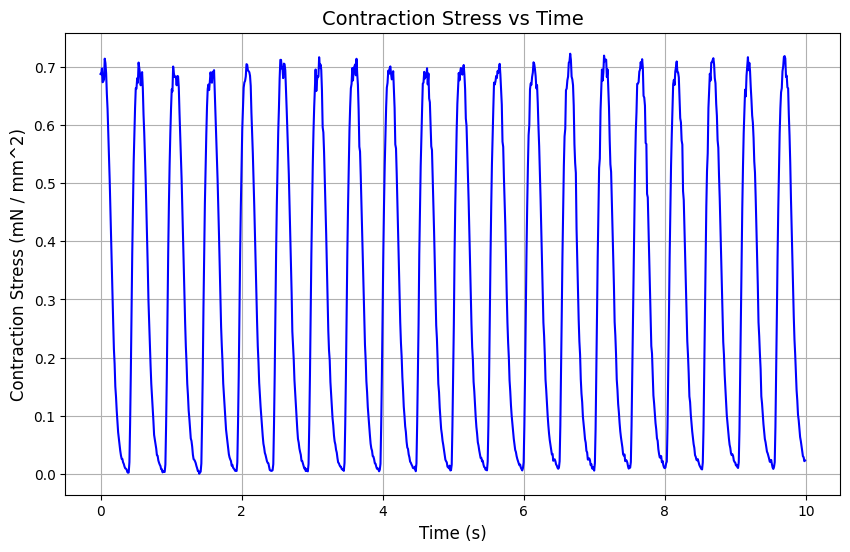

In [3]:
frame_rate_per_sec = 100
frame_time_point_sec = frame_time_point / 100
sampling_rate = frame_rate_per_sec

plt.figure(figsize=(10, 6))
plt.plot(frame_time_point_sec, contraction_stress, linestyle='-', color='b')
plt.title('Contraction Stress vs Time', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Contraction Stress (mN / mm^2)', fontsize=12)
plt.grid(True)
plt.show()

In [4]:
peaks, peak_properties = find_peaks(contraction_stress, prominence=0.1)
# Step 2: Estimate contraction frequency
peak_intervals = np.diff(frame_time_point_sec[peaks])  # Time difference between peaks
mean_interval = np.mean(peak_intervals)
estimated_freq = 1 / mean_interval  # in Hz
print(f"Estimated contraction frequency: {estimated_freq:.2f} Hz")


Estimated contraction frequency: 1.97 Hz


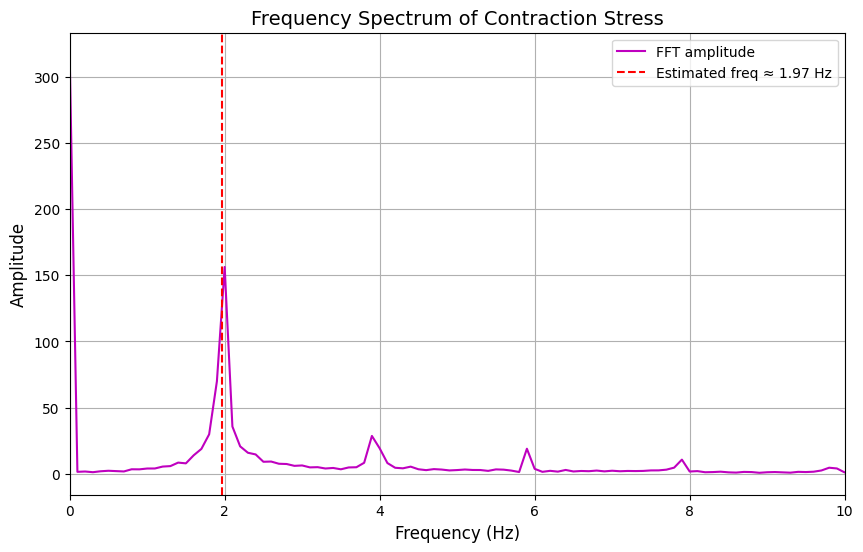

In [5]:
##FTT
N = len(contraction_stress)

# 3. Perform FFT
fft_values = np.fft.fft(contraction_stress)
fft_freq = np.fft.fftfreq(N, d=1/sampling_rate)

# Keep only positive frequencies
positive_freqs = fft_freq[:N // 2]
positive_fft = np.abs(fft_values[:N // 2])

# 4. Plot FFT
plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_fft, color='m', label='FFT amplitude')
plt.axvline(estimated_freq, color='r', linestyle='--', label=f'Estimated freq ≈ {estimated_freq:.2f} Hz')
plt.title('Frequency Spectrum of Contraction Stress', fontsize=14)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True)
plt.xlim(0, 10)  # Zoom on 0-10 Hz range
plt.legend()
plt.show()

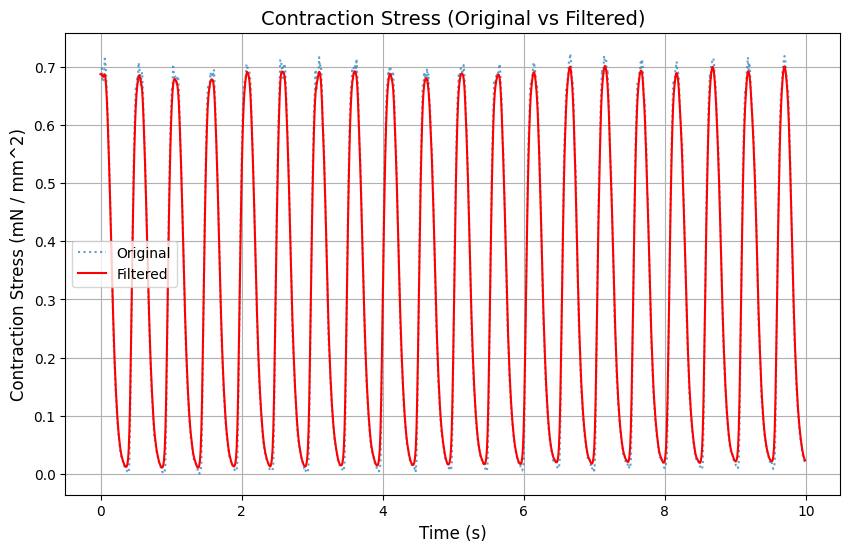

In [6]:
# Step 3: Design Butterworth LPF
nyquist_freq = 0.5 * sampling_rate

cutoff_freq = estimated_freq * 5  # make sure this is < 50 Hz

if cutoff_freq >= nyquist_freq:
    cutoff_freq = nyquist_freq * 0.9  # cap it to safe value

normal_cutoff = cutoff_freq / nyquist_freq  # must be between 0 and 1
b, a = butter(N=1, Wn=normal_cutoff, btype='low', analog=False)

# 5. Apply filter
filtered_stress = filtfilt(b, a, contraction_stress)

# 6. Plot
plt.figure(figsize=(10, 6))
plt.plot(frame_time_point_sec, contraction_stress, linestyle=':', label='Original', alpha=0.7)
plt.plot(frame_time_point_sec, filtered_stress, linestyle='-', label='Filtered', color='r')
plt.title('Contraction Stress (Original vs Filtered)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Contraction Stress (mN / mm^2)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

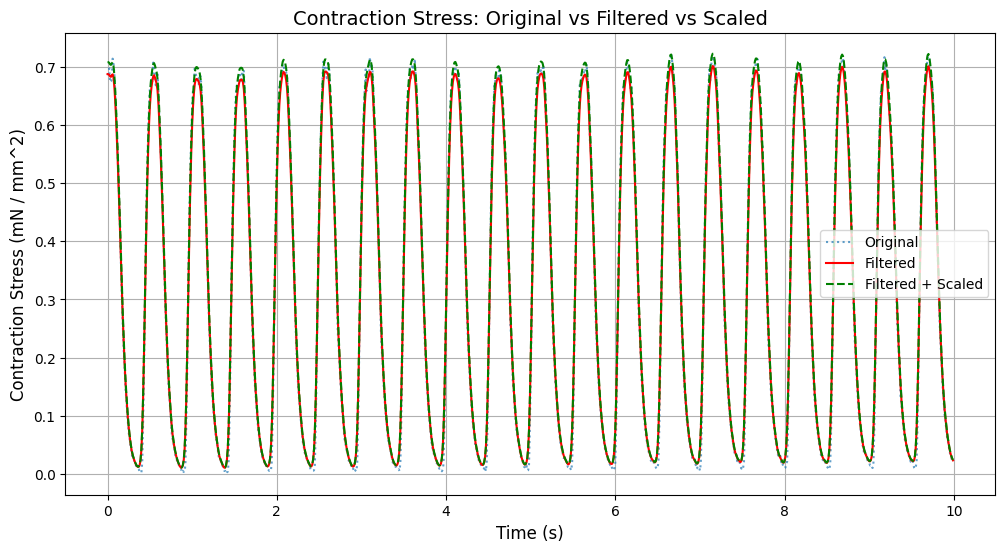

In [7]:
# 1. Calculate scaling factor
scale_factor = np.max(contraction_stress) / np.max(filtered_stress)

# 2. Apply scaling
filtered_stress_scaled = filtered_stress * scale_factor

# 3. Plot original vs filtered vs scaled
plt.figure(figsize=(12, 6))
plt.plot(frame_time_point_sec, contraction_stress, linestyle=':', label='Original', alpha=0.7)
plt.plot(frame_time_point_sec, filtered_stress, linestyle='-', label='Filtered', color='red')
plt.plot(frame_time_point_sec, filtered_stress_scaled, linestyle='--', label='Filtered + Scaled', color='green')
plt.title('Contraction Stress: Original vs Filtered vs Scaled', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Contraction Stress (mN / mm^2)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()